In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from spacy import displacy
from spacy import tokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_colour = '#00bfbf'

In [3]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


<Axes: xlabel='fake_or_factual'>

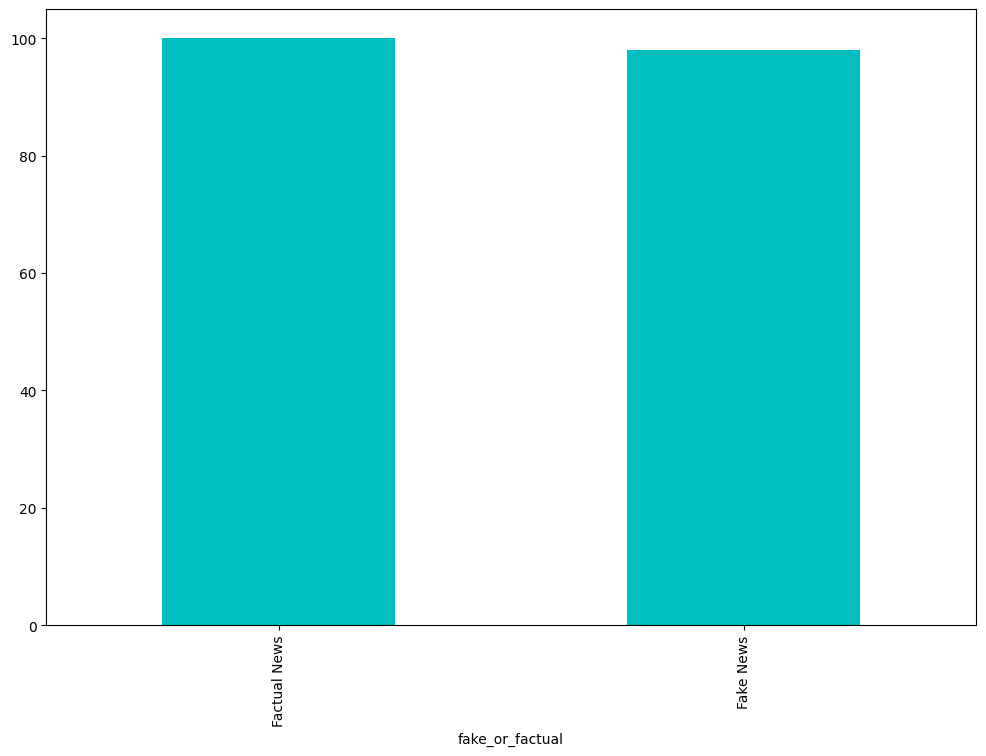

In [4]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)

## POS Tagging

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
# split data by fake news
fake_news_data = data[data['fake_or_factual'] == 'Fake News']
fake_news_data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News


In [7]:
# split data by factual news
fact_news_data = data[data['fake_or_factual'] == 'Factual News']
fact_news_data.head()

,title,text,date,fake_or_factual
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News
11,Kerry says can't comment on content of Clinton...,QUEBEC CITY (Reuters) - U.S. Secretary of Stat...,"January 29, 2016",Factual News


In [8]:
fake_spacydocs = list(nlp.pipe(fake_news_data['text']))
fact_spacydocs = list(nlp.pipe(fact_news_data['text']))

In [9]:
# creating function to extract tags for each document in our data
def extract_token_tag(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [10]:
# tagging fake dataset
fake_tags = []
columns = ['token', 'ner_tag', 'pos_tag']

for ix,doc in enumerate(fake_spacydocs):
    tags = extract_token_tag(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fake_tags.append(tags)

fake_tagsdf = pd.concat(fake_tags)

In [11]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [12]:
# tagging for factual data
fact_tag = []
columns = ['token', 'ner_tag', 'pos_tag']

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tag(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fact_tag.append(tags)

fact_tagdf = pd.concat(fact_tag)
fact_tagdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [13]:
# token frequency count(fake)
fake_tag_count = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='count').sort_values(by='count', ascending=False)
fake_tag_count.head(10)

,token,pos_tag,count
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [14]:
# token frequency count(fact)
fact_tag_count = fact_tagdf.groupby(['token', 'pos_tag']).size().reset_index(name='count').sort_values(by='count', ascending=False)
fact_tag_count.head(10)

,token,pos_tag,count
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [15]:
# frequency of pos tag(fake)
fake_tag_count.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
DET        42
INTJ       24
PUNCT      23
CCONJ      19
X          14
PART       10
SYM         5
SPACE       3
Name: token, dtype: int64

In [16]:
# frequency of pos tag(fact)
fact_tag_count.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
DET        36
PUNCT      22
SPACE      11
CCONJ      11
X          10
INTJ        7
PART        7
SYM         4
Name: token, dtype: int64

In [17]:
## Diving into Nouns(fake)
fake_tag_count[fake_tag_count['pos_tag'] == 'NOUN'][0:11]

,token,pos_tag,count
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [18]:
## Diving into Nouns(fact)
fact_tag_count[fact_tag_count['pos_tag'] == 'NOUN'][0:11]

,token,pos_tag,count
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Enitites

In [19]:
top_entites_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(["token", 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entites_fake.head()

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75


In [20]:
top_entites_fact = fact_tagdf[fact_tagdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entites_fact.head()

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124


In [21]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

<Axes: xlabel='counts', ylabel='token'>

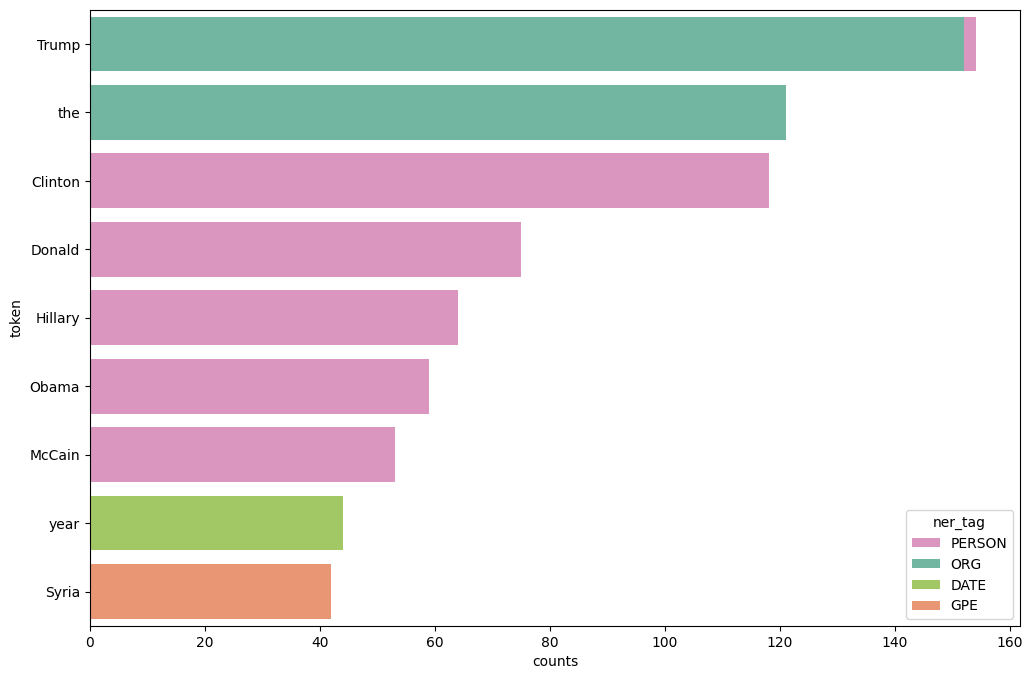

In [22]:
sns.barplot(data=top_entites_fake[:10], x='counts', y='token', hue='ner_tag', palette=ner_palette, orient='h', dodge=False)

<Axes: xlabel='counts', ylabel='token'>

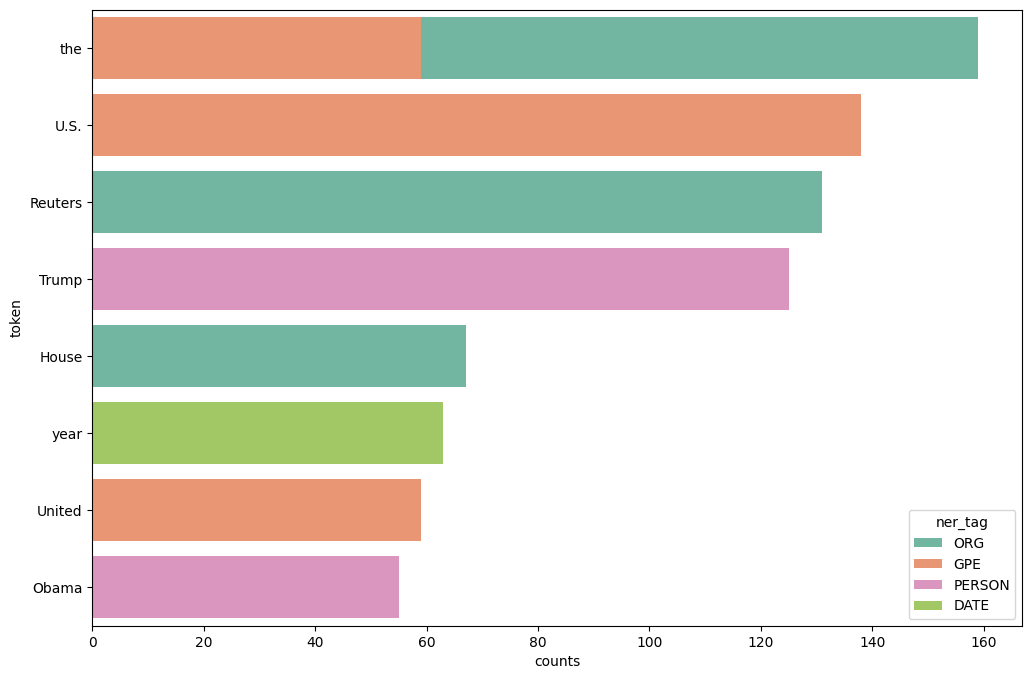

In [23]:
sns.barplot(data=top_entites_fact[:10], x='counts', y='token', hue='ner_tag', palette=ner_palette, orient='h', dodge=False)

## Text Preprocessing


In [24]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [25]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['clean_text'] = data['text'].apply(lambda x: re.sub(r'^[^-]*-\s*', '', x))

In [26]:
#Lowercasing
data['clean_text'] = data['clean_text'].str.lower()

In [27]:
#removing punctuations
data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'([^\w\s])', '', x))

In [28]:
#stop-words removal
en_stopwords = stopwords.words('english')
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [29]:
#tokeniztion
data['clean_text'] = data['clean_text'].apply(lambda x: word_tokenize(x))

In [30]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
data['clean_text'] = data['clean_text'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [31]:
# Unigrams
tokens_clean = sum(data['clean_text'], [])
unigram = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigram)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


C:\Users\sahil\AppData\Local\Temp\ipykernel_14572\1220439240.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=unigram, x='count', y='token', hue='token', palette=[default_plot_colour], orient='h', legend=False)


<Axes: xlabel='count', ylabel='token'>

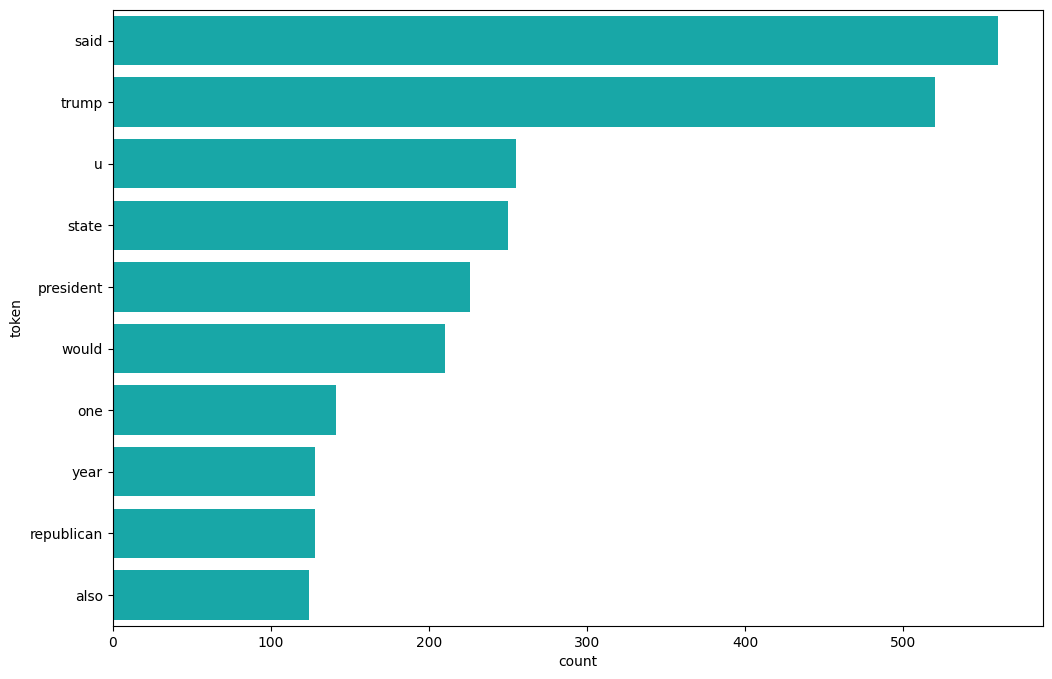

In [32]:
unigram['token'] = unigram['index'].apply(lambda x: x[0])

sns.barplot(data=unigram, x='count', y='token', hue='token', palette=[default_plot_colour], orient='h', legend=False)

In [33]:
# Bigram
bigram = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigram)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


C:\Users\sahil\AppData\Local\Temp\ipykernel_14572\4226176096.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=bigram, x='count', y='token', hue='token', palette=[default_plot_colour], orient='h', legend=False)


<Axes: xlabel='count', ylabel='token'>

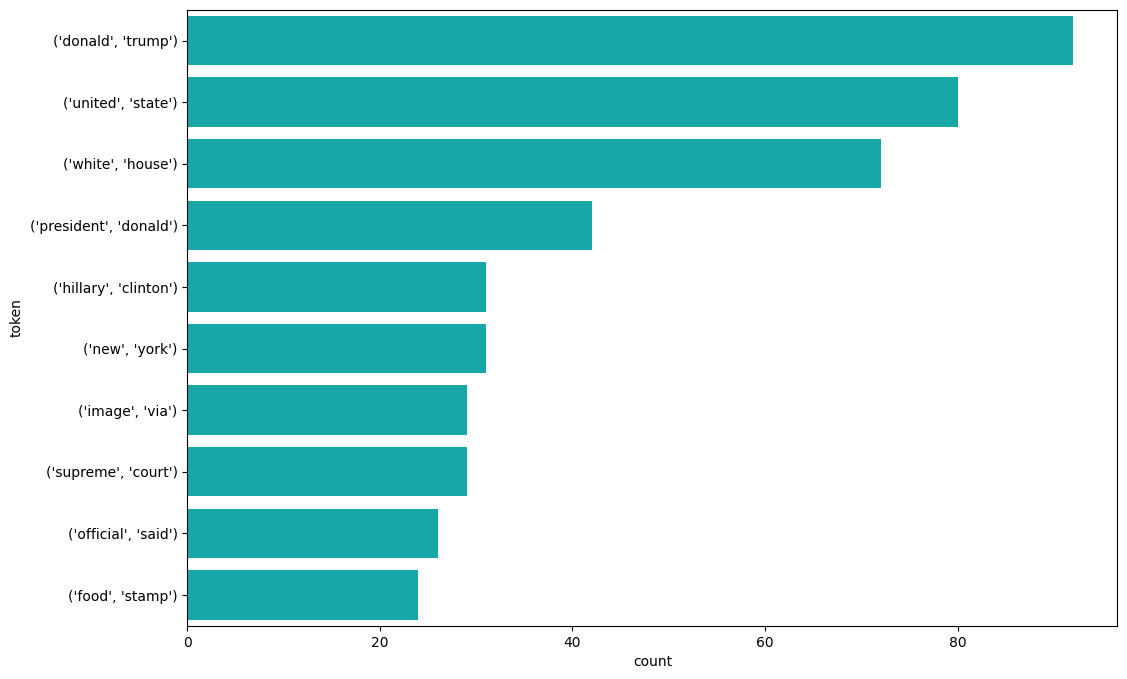

In [34]:
bigram['token'] = bigram['index'].apply(lambda x: str(x))

sns.barplot(data=bigram, x='count', y='token', hue='token', palette=[default_plot_colour], orient='h', legend=False)

## Sentiment Analysis

In [35]:
vader_sentiment = SentimentIntensityAnalyzer()

In [38]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])
data.head()

,title,text,date,fake_or_factual,clean_text,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [40]:
bins = [-1,-0.1,0.1,1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins=bins, labels=names)
data.head()

,title,text,date,fake_or_factual,clean_text,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

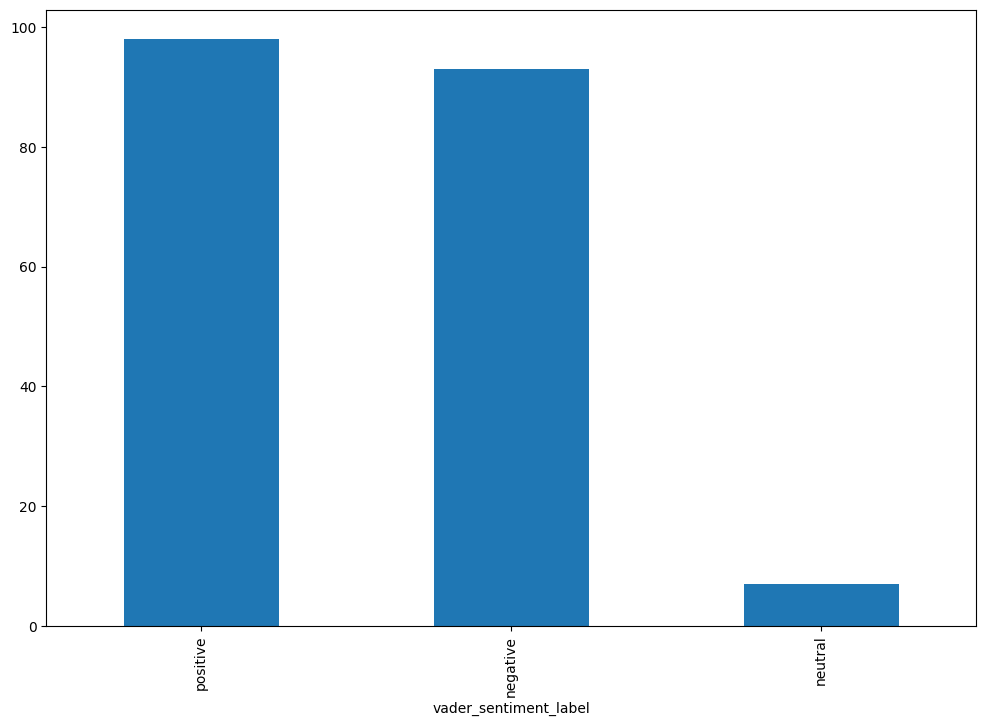

In [42]:
data['vader_sentiment_label'].value_counts().plot.bar()

C:\Users\sahil\AppData\Local\Temp\ipykernel_14572\3009406880.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(data=data, x='fake_or_factual', hue= 'vader_sentiment_label', palette = sns.color_palette("hls"))


<Axes: xlabel='fake_or_factual', ylabel='count'>

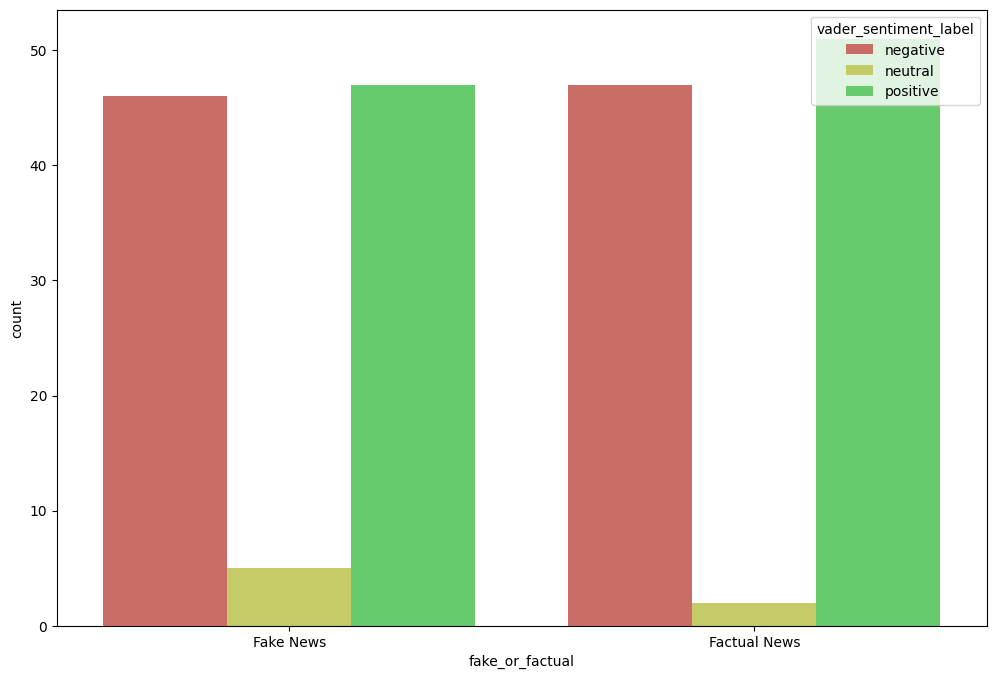

In [43]:
sns.countplot(data=data, x='fake_or_factual', hue= 'vader_sentiment_label', palette = sns.color_palette("hls"))

## Topic Modelling

### LDA

In [47]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['clean_text'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

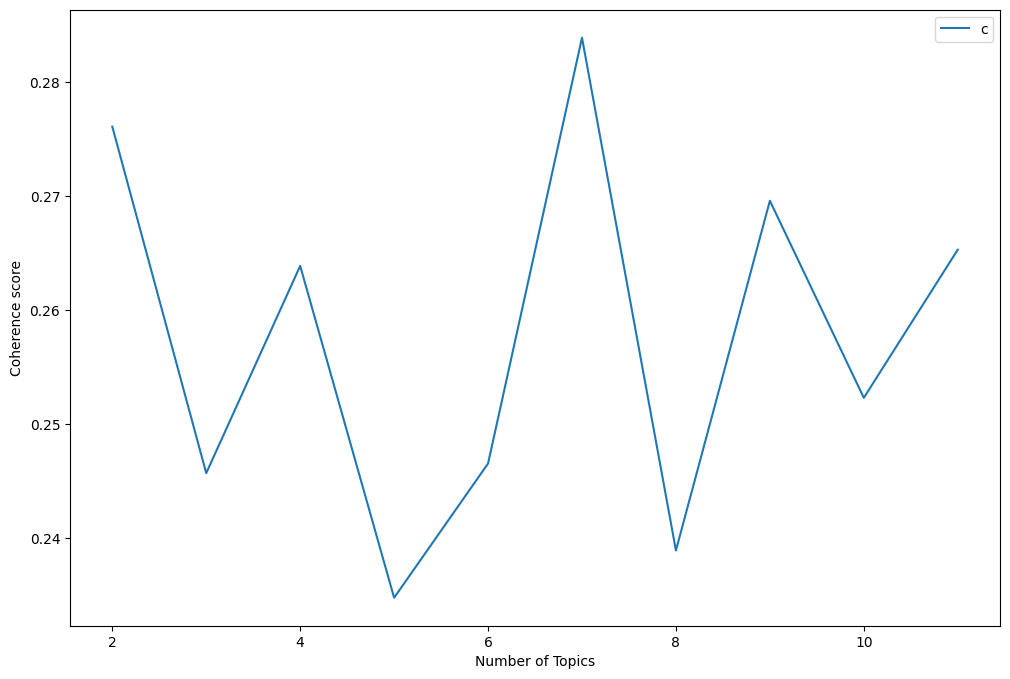

In [49]:
# generating coherence scores to determine an optimum number of topics
coherence_value = []
model_list = []

min_topics = 2
max_topics = 11

for num_topic in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topic, id2word=dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts= fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_value.append(coherence_model.get_coherence())

plt.plot(range(min_topics, max_topics+1), coherence_value)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# create lda model
num_topics_fake = 7 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.005*"u" + 0.004*"president" + 0.004*"state" + 0.004*"year" + 0.004*"mccain" + 0.003*"syria" + 0.003*"trump" + 0.003*"clinton" + 0.003*"would" + 0.003*"woman"'),
 (1,
  '0.006*"said" + 0.006*"clinton" + 0.006*"woman" + 0.005*"trump" + 0.005*"president" + 0.004*"republican" + 0.004*"time" + 0.004*"student" + 0.004*"u" + 0.003*"would"'),
 (2,
  '0.011*"trump" + 0.005*"said" + 0.005*"president" + 0.005*"state" + 0.005*"would" + 0.004*"one" + 0.004*"also" + 0.003*"clinton" + 0.003*"republican" + 0.003*"people"'),
 (3,
  '0.011*"trump" + 0.005*"said" + 0.004*"clinton" + 0.004*"state" + 0.004*"president" + 0.004*"one" + 0.003*"year" + 0.003*"u" + 0.003*"would" + 0.003*"obama"'),
 (4,
  '0.020*"trump" + 0.005*"would" + 0.005*"republican" + 0.004*"one" + 0.004*"said" + 0.004*"president" + 0.003*"clinton" + 0.003*"people" + 0.003*"image" + 0.003*"woman"'),
 (5,
  '0.010*"trump" + 0.004*"time" + 0.004*"said" + 0.003*"state" + 0.003*"like" + 0.003*"clinton" + 0.003*"people" + 0.003*"imag

### LSI Model

In [51]:
def tfidf_corpus(doc_term_matrix):
    # creating a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [52]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generating coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

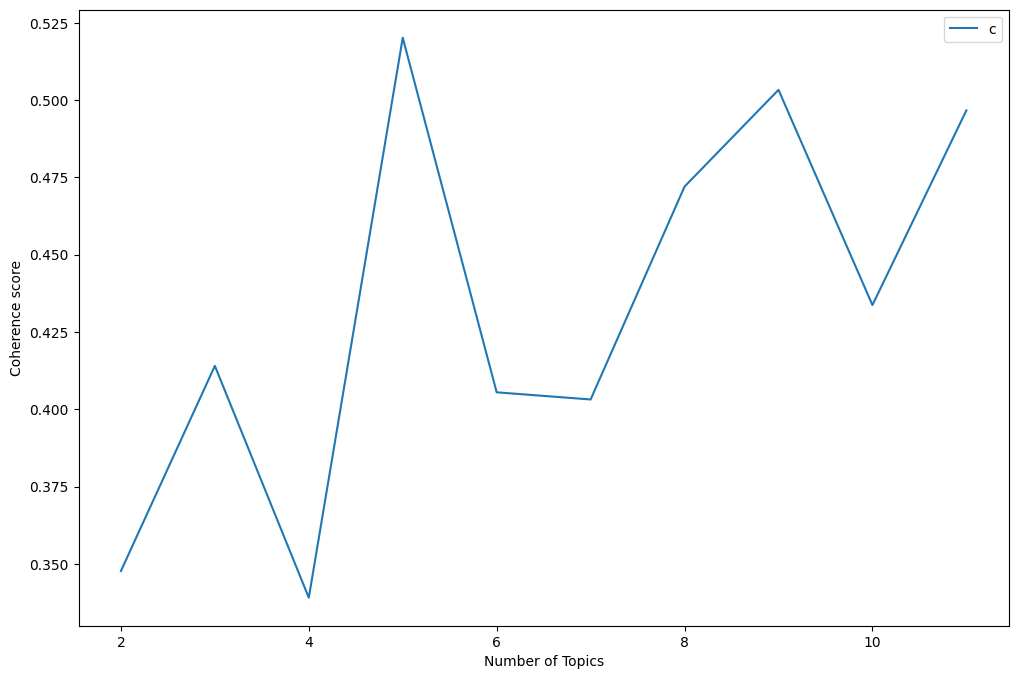

In [53]:
# creating tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [54]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"savant" + -0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

## Predict fake or factual news 

In [56]:
X = [','.join(map(str, l)) for l in data['clean_text']]
Y = data['fake_or_factual']

In [58]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [59]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [60]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [61]:
y_pred_lr = lr.predict(X_test)

In [62]:
accuracy_score(y_pred_lr, y_test)

0.8666666666666667

In [63]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.83      0.94      0.88        31
   Fake News       0.92      0.79      0.85        29

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



In [64]:
svm = SGDClassifier().fit(X_train, y_train)

In [65]:
y_pred_svm = svm.predict(X_test)

In [66]:
accuracy_score(y_pred_svm, y_test)

0.9

In [67]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.84      1.00      0.91        31
   Fake News       1.00      0.79      0.88        29

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60

